Zachary Lochmueller - 384 Project 

Title: Transportation Problems and Analyzing Basic Feasible Solution Algorithms

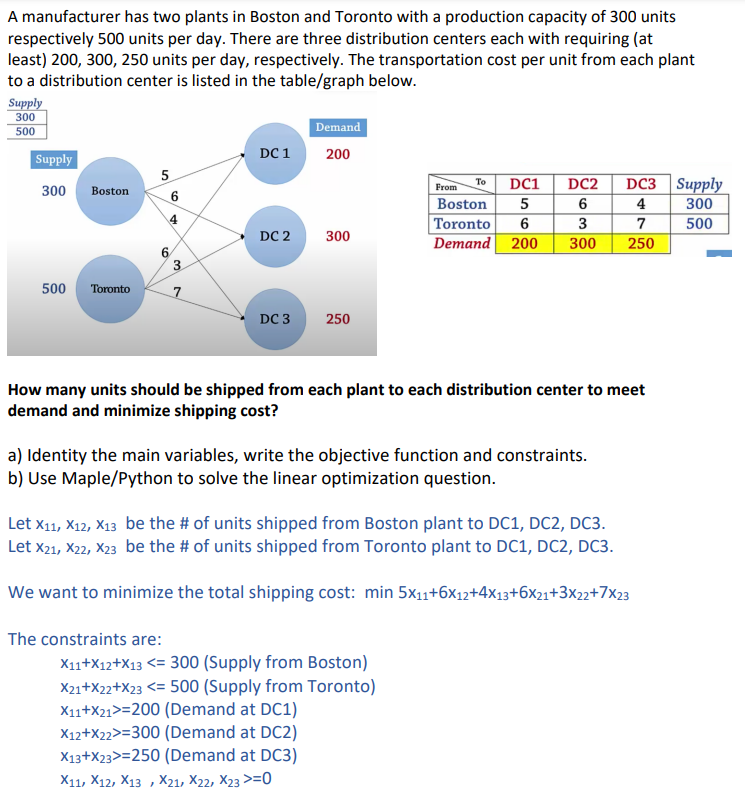

Transportation problems are a subset of linear programming problems which involve finding the minimum cost of transporting supply to meet demand. Typically, these can be factories shipping goods to stores, but the same set up also applies to problems involving assignment of employees to shifts. Constraints for both usually involve requiring that all supply (or every employee) reaches a factory (or is assigned a shift), all demand is satisfied (either for an amount of supply or for a certain shift), with a minimum cost being achieved (whether that be transportation cost or labor cost). 

While these problems can be solved using classical linear programming methods such as the simplex method, there do exist special algorithms for these types of problems which are more computationally efficient. In "Concepts of Mathematical Modelling" Chapter 4, Meyer introduces the Northwest Corner rule and Stepping Stone method as two such methods which together provide an optimal solution to transportation problems, typically with a lower computational cost than the simplex method. Without getting too deep into considering the time and space complexities of the algorithms, this project aims to demonstrate why this special algorithm outperforms the simplex method. 

Steps for our special algorithm:

1. Balance the problem 
2. Use NW Corner Rule
3. Use Stepping Stone method to find optimal solution


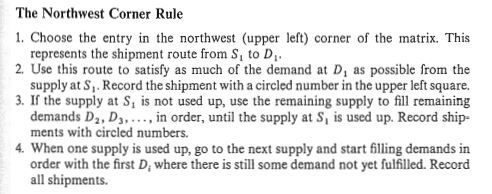


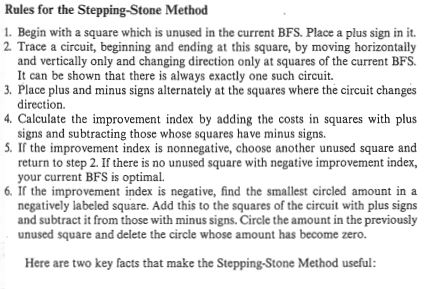

The code below includes my functions for randomly generating sample transportation problems, demonstrating how they can be balanced if unbalanced, and a Northwest Corner function which creates a basic feasible solution from sample problems (with and without the Minimum Entry optimization). The code blocks below the function definitions break down each of these steps with sample output included, and from that a discussion about how much more work the Stepping Stone method would need to do gives a good idea of the computational costs saved as a result of using this special algorithm.

In [ ]:
import numpy as np
from scipy.optimize import linprog

def totalCostSquare(bfs, costs):
  # calculates total cost of bfs using costs matrix, assumed to be n x n 
  total = 0
  for i, row in enumerate(costs):
    for j, cost in enumerate(row):
      total += cost * bfs[i][j]
  return total

def makeBalanced(costs, supply, demand):
  # creates one new supply/demand location depending on how supply/demand is unbalanced
  supply_total = sum(supply)
  demand_total = sum(demand)
  supply_new = list(supply.copy())
  demand_new = list(demand.copy())

  if supply_total < demand_total:
    print("Supply less than demand, added penalty supply location.")
    supply_new.append(demand_total - supply_total)
    costs_new = np.vstack([costs, np.random.randint(0,5,len(supply))])
    return costs_new, supply_new, demand
  if supply_total > demand_total:
    print("Supply greater than demand, added storage demand location.")
    demand_new.append(supply_total - demand_total)
    costs_new = np.hstack([costs, np.zeros((costs.shape[0], 1), dtype=costs.dtype)])
    return costs_new, supply, demand_new
  
  return costs, supply, demand  

def makeMinimumEntry(costs, supply, demand):
  # finds lowest cost entry, permute costs to make it first entry
  # permutes supply and demand accordingly
  min = np.min(costs)
  edit = False
  if costs[0][0] != min:
    # returns indices of minimum elements in cost matrix
    min_index = np.argwhere(costs == min)
    # take 1st minimum from set of choices
    min = min_index[0]
    # swap row 0 with min cost row
    costs[[0, min[0]]] = costs[[min[0], 0]]
    # swap col 0 with min cost col
    costs[:, [0, min[1]]] = costs[:, [min[1],0]]
    # swap rows/col in supply/demand
    supply[0], supply[min[0]] = supply[min[0]], supply[0]
    demand[0], demand[min[1]] = demand[min[1]], demand[0]
    edit = True
  return edit, costs, supply, demand

def generateBalancedTp(degree):
  # creates Balanced TP by adding supply/demand point to satisfy contraint
  demand = np.random.randint(1,50,degree)
  supply = np.random.randint(1,50,degree) 
  costs = np.random.randint(1,10,(len(supply),len(demand)))
  costs, supply, demand = makeBalanced(costs, supply, demand)
  return costs, supply, demand

def generateSimpleTp(degree):
  # creates Balanced TP by creating balanced supply from random demand
  demand = np.random.randint(1,50,degree)
  supply = np.flip(demand)
  costs = np.random.randint(1,10,(len(supply),len(demand)))

  return costs, supply, demand

def solveLP(adj, c, b):
  # fixed size of 4x4 cost matrix, 16x16 adjacency
  bound = 16*[(0,None)]
  res = linprog(c, adj, b, bounds=bound, method='simplex')
  return res

def make44Adjacency(costs, supply, demand):
  # makes costs, supply, demand into adjacency, b (supply/demand), and c (costs)
  size = 1
  s_size = len(supply)
  for dim in np.shape(costs): size *= dim
  # size equals number of elements in costs
  output = np.zeros((len(supply) + len(demand), size))
  c = costs.flatten()
  neg_demand = -1*demand
  b = list(supply) + list(neg_demand)

  # gross code but makes the 16 x 16 adjacency graph
  for i, row in enumerate(output):
    if i == 0:
      row[i:s_size] = 1
    if i == 1:
      row[s_size:2*s_size] = 1
    if i == 2:
      row[2*s_size:3*s_size] = 1
    if i == 3:
      row[3*s_size:4*s_size] = 1
    if i == 4:
      row[0] = -1
      row[0+s_size] = -1
      row[0+s_size*2] = -1
      row[0+s_size*3] = -1
    if i == 5:
      row[1] = -1
      row[1+s_size] = -1
      row[1+s_size*2] = -1
      row[1+s_size*3] = -1
    if i == 6:
      row[2] = -1
      row[2+s_size] = -1
      row[2+s_size*2] = -1
      row[2+s_size*3] = -1
    if i == 7:
      row[3] = -1
      row[3+s_size] = -1
      row[3+s_size*2] = -1
      row[3+s_size*3] = -1
  return output, c, b

def bfsNWCorner(costs, supply, demand):
  # finds BFS using Northwest Corner rule
  row_size = len(supply)
  col_size = len(demand)
  output = np.zeros_like(costs)
  i = 0
  j = 0
  vars = []
  while len(vars) < row_size + col_size - 1:
    x = min(supply[i], demand[j])
    output[i][j] = x
    vars.append(x)
    supply[i] -= x
    demand[j] -= x
    if supply[i] == 0 and i < row_size-1:
        i += 1
    elif demand[j] == 0 and j < col_size-1:
        j += 1
  return output

The Northwest Corner rule requires that our transportation problem in question is balanced. This means that the supply must be able to exactly meet the demand. This seems like it could constrain us from considering more realistic scenarios, however there are methods for making a transportation problem balanced that should work in most cases. In the case of demand exceeding supply, the costs matrix can be appended with a new row which represents a "financial penalty" supply point which can track the cost of not fulfilling that demand. Similarly, in the case of supply exceeding demand, the costs matrix can be appended with a new column which represents a "storage" demand point, where the costs represent how costly it is to store that extra supply (zero if supply can sit in stores, or non-zero to represent the cost of sending goods to storage). 

In [ ]:
costs, supply, demand = generateBalancedTp(6)
print("Costs matrix =\n",costs)
print("Supply =",supply)
print("Demand =",demand)

Supply less than demand, added penalty supply location.
Costs matrix =
 [[5 7 6 9 5 8]
 [2 6 9 2 9 2]
 [6 3 7 4 8 2]
 [5 3 7 6 4 7]
 [1 4 2 1 8 8]
 [2 9 6 3 1 3]
 [2 4 1 1 1 2]]
Supply = [12, 5, 5, 7, 2, 16, 147]
Demand = [39 41 22 46 27 19]


In [ ]:
costs, supply, demand = generateBalancedTp(6)
print("Costs matrix =\n",costs)
print("Supply =",supply)
print("Demand =",demand)

Supply greater than demand, added storage demand location.
Costs matrix =
 [[9 8 4 7 2 7 0]
 [3 6 8 7 8 9 0]
 [4 2 9 6 5 8 0]
 [3 7 7 9 3 5 0]
 [8 7 7 9 3 7 0]
 [1 3 2 9 3 8 0]]
Supply = [43 22 10  3 36  7]
Demand = [41, 20, 13, 7, 35, 3, 2]


The NW Corner rule (steps shown below) always results in a basic feasible solution, as it is greedily filling the orders and traversing from the NW corner to the SE corner of the costs matrix. The variables it chooses for each point in this BFS may not be an optimal solution, so to help it along the Minimum Entry method is used which is a simple row/column switch that guarantees the first entry is a minimum entry. Together, these can provide a BFS that may already be close to the optimal solution. Then, the stepping stone method can be applied, and this whole process will end up using less operations than the simplex method. 

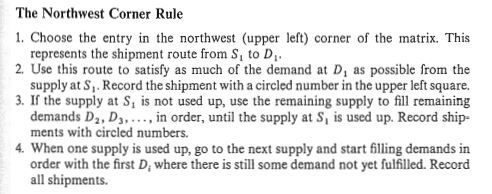


The code block below demonstrates the NW Corner rule when run on a sample problem using the Minimum Entry method and when run without it. Generally, there are significant improvements when the size of the problem and the distance between the minimum and maximum cost are large. Occasionally, it gives a new BFS that has a higher cost, but on average it results in an improvement. When run on a costs matrix that already has a minimum entry as its first entry, the Minimum Entry function will just return the same matrix back again. If there are multiple entries with the minimum entry, the closest one to the first entry is chosen. 

In [ ]:
# shows minimum entry method comparison on sample tp 

costs, supply, demand = generateSimpleTp(7)

print("Costs matrix =\n",costs)
print("Supply =",supply)
print("Demand =",demand)
bfs_noMin = bfsNWCorner(costs.copy(), supply.copy(), demand.copy())

print("BFS Cost No Min =", totalCostSquare(bfs_noMin, costs))
print(bfs_noMin)

flag, costs, supply, demand = makeMinimumEntry(costs.copy(), supply.copy(), demand.copy())

print("New Cost Matrix\n",costs)


bfs_Min = bfsNWCorner(costs.copy(), supply.copy(), demand.copy())

print("BFS Cost w/ Min =", totalCostSquare(bfs_Min, costs))

print(bfs_Min)


Costs matrix =
 [[2 6 2 3 7 4 6]
 [4 6 9 3 7 6 6]
 [6 7 6 7 4 8 3]
 [7 5 8 7 7 9 6]
 [8 7 8 5 6 7 1]
 [8 5 2 9 1 9 9]
 [5 6 1 3 9 9 1]]
Supply = [47  7 30 24 48 26 20]
Demand = [20 26 48 24 30  7 47]
BFS Cost No Min = 1153
[[20 26  1  0  0  0  0]
 [ 0  0  7  0  0  0  0]
 [ 0  0 30  0  0  0  0]
 [ 0  0 10 14  0  0  0]
 [ 0  0  0 10 30  7  1]
 [ 0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0 20]]
New Cost Matrix
 [[1 7 8 5 6 7 8]
 [6 6 9 3 7 6 4]
 [3 7 6 7 4 8 6]
 [6 5 8 7 7 9 7]
 [6 6 2 3 7 4 2]
 [9 5 2 9 1 9 8]
 [1 6 1 3 9 9 5]]
BFS Cost w/ Min = 841
[[47  1  0  0  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0 18 12  0  0  0  0]
 [ 0  0 24  0  0  0  0]
 [ 0  0 12 24 11  0  0]
 [ 0  0  0  0 19  7  0]
 [ 0  0  0  0  0  0 20]]


These final two code blocks show a BFS from NW Corner method without using Minimum Entry, compared to the optimal solution found using the simplex method. Then, a BFS from NW Corner method with using Minimum Entry is compared to its optimal solution found using the simplex method, and the result is usually much closer. Then, the stepping stone method can be used to find an optimal solution, and usually it only takes a few loops. The currently run outputs should demonstrate this, but feel free to run any of the blocks to see the results for a different sample problem. Ideally, it would be better to see these algorithms run on transportation problems larger than 4 x 4, but I was having some trouble with converting costs matrices to adjacency matrices so this is as good as it gets for now! 

In [ ]:
# 1
# Generates 4x4 tp, NWC bfs w/ BV entries w/o Minimum Entry method
costs, supply, demand = generateSimpleTp(4)
print("Costs matrix =\n",costs)
print("Supply =",supply)
print("Demand =",demand)
bfs_noMin = bfsNWCorner(costs.copy(), supply.copy(), demand.copy())
print("BFS Cost =",totalCostSquare(bfs_noMin, costs))
print(bfs_noMin)

# Show optimal cost and solution BV entries
output, c, b = make44Adjacency(costs.copy(), supply.copy(), demand.copy())
res = solveLP(output, c, b)
output = np.resize(res.x.astype(int), (4,4))
print("Optimal Cost:",res.fun.astype(int))
print(output)
print(res)

Costs matrix =
 [[5 4 7 4]
 [7 7 1 5]
 [8 9 9 8]
 [2 4 8 4]]
Supply = [ 1 15 39 30]
Demand = [30 39 15  1]
BFS Cost = 627
[[ 1  0  0  0]
 [15  0  0  0]
 [14 25  0  0]
 [ 0 14 15  1]]
Optimal Cost: 429
[[ 0  1  0  0]
 [ 0  0 15  0]
 [ 0 38  0  1]
 [30  0  0  0]]
     con: array([], dtype=float64)
     fun: 429.0
 message: 'Optimization terminated successfully.'
     nit: 16
   slack: array([0., 0., 0., 0., 0., 0., 0., 0.])
  status: 0
 success: True
       x: array([ 0.,  1.,  0.,  0.,  0.,  0., 15.,  0.,  0., 38.,  0.,  1., 30.,
        0.,  0.,  0.])


In [ ]:
# 2 (run previous code block then this one)
# Uses previous 4x4 tp, NWC bfs w/ BV entries w/ Minimum Entry method
flag, costs, supply, demand = makeMinimumEntry(costs.copy(), supply.copy(), demand.copy())
print("New Cost Matrix\n",costs)
print("Supply =",supply)
print("Demand =",demand)
bfs_Min = bfsNWCorner(costs.copy(), supply.copy(), demand.copy())
print("BFS Cost =",totalCostSquare(bfs_Min, costs.copy()))
print(bfs_Min)
print("Edited =",flag)

# Shows optimal cost and solution BV entries
output, c, b = make44Adjacency(costs.copy(), supply.copy(), demand.copy())
res = solveLP(output, c, b)
output = np.resize(res.x.astype(int), (4,4))
print("Optimal Cost:",res.fun.astype(int))
print(output)
print(res)

New Cost Matrix
 [[1 7 7 5]
 [7 4 5 4]
 [9 9 8 8]
 [8 4 2 4]]
Supply = [15  1 39 30]
Demand = [15 39 30  1]
BFS Cost = 431
[[15  0  0  0]
 [ 0  1  0  0]
 [ 0 38  1  0]
 [ 0  0 29  1]]
Edited = True
Optimal Cost: 429
[[15  0  0  0]
 [ 0  1  0  0]
 [ 0 38  0  1]
 [ 0  0 30  0]]
     con: array([], dtype=float64)
     fun: 429.0
 message: 'Optimization terminated successfully.'
     nit: 19
   slack: array([0., 0., 0., 0., 0., 0., 0., 0.])
  status: 0
 success: True
       x: array([15.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 38.,  0.,  1.,  0.,
        0., 30.,  0.])
